## P6 Détection de faux billets de banques

### 1. Analyse exploratoire
#### 1.1 méthode K-means
#### 1.2 réduction de la dimension avec l'ACP et analyse des variables
### 2. Regression logistique
### 3. Outil de prédiction

In [1]:
#importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from matplotlib import cm
import seaborn as sns
#from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
#from sklearn import metrics
from sklearn.decomposition import PCA

import statsmodels.api as sm
from scipy.stats import shapiro, ttest_ind

### 0. Cleaning

In [2]:
#importation des données dans des dataframes
df = pd.read_csv("notes.csv")
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [3]:
df['is_genuine'] = pd.get_dummies(df['is_genuine'], drop_first=True)
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.67,103.74,103.70,4.01,2.87,113.29
2,1,171.83,103.76,103.76,4.40,2.88,113.84
3,1,171.80,103.78,103.65,3.73,3.12,113.63
4,1,172.05,103.70,103.75,5.04,2.27,113.55


In [4]:
#recherche de potentiels duplicates du fichier df
df.duplicated(keep=False)
if 'True' in (df.duplicated(subset=['diagonal','height_left'],keep=False)):
    print('présence un doublon')
else:
    print('pas de doublons') 

pas de doublons


In [5]:
#pas de null
df.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

### 1. analyse exploratoire et étude des variables

In [6]:
#on prepare les données et paramètre le modèle k-means
data_k = scale(df.drop('is_genuine', axis=1))

In [7]:
# On fait une boucle pour faire le modèle
distortions = []
K = range(1,10)
for k in K:
    model = KMeans(n_clusters=k)
    model.fit(data_k)
    distortions.append(model.inertia_)

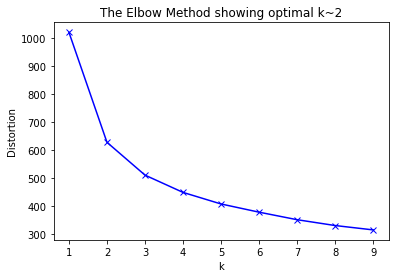

In [8]:
# On plot graphiquement une courbe 'Elbow'
plt.figure(figsize=(6,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing optimal k~2')
#plt.savefig("elbow_for_best_k.png")
plt.show()

In [9]:
#on re-paramètre model
model = KMeans(n_clusters = 2, init = 'k-means++', n_init = 10)
#On entre les données du DF
k_means = model.fit(data_k)

In [10]:
# on sort le label du cluster dans une nouvelle variable
df['cluster'] = k_means.labels_
df['cluster'].value_counts()

0    93
1    77
Name: cluster, dtype: int64

In [11]:
#la classification k-means correspond-t-elle à celle réelle donnée par 'is_genuine'?
pd.crosstab(df.is_genuine, df.cluster)

cluster,0,1
is_genuine,,
0,1,69
1,92,8


#### =>oui on a un seul faux positif/ 8 faux négatifs par k-means, on a cross-validé les groupes

### on sort les plus grandes corrélations
### (code emprunté ici https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas )

In [12]:
df.drop(['is_genuine','cluster'], axis=1).corr()

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


In [13]:
#on plot une matrice de correlation
corr_matrix = df.drop(['is_genuine','cluster'], axis=1).corr().abs()
#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
                  #.stack()
                  #.sort_values(ascending=False))
# Color NaNs grey
sol.style\
    .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)\
    .highlight_null(null_color='#f1f1f1')\
    .format(precision=2)

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,nan,0.32,0.22,0.18,0.03,0.08
height_left,nan,nan,0.73,0.42,0.32,0.42
height_right,nan,nan,nan,0.51,0.37,0.42
margin_low,nan,nan,nan,nan,0.17,0.64
margin_up,nan,nan,nan,nan,nan,0.53
length,nan,nan,nan,nan,nan,nan


In [14]:
#Top 5 plus grandes corrélations
sol.stack().sort_values(ascending=False).head(5)

height_left   height_right    0.734390
margin_low    length          0.637352
margin_up     length          0.525284
height_right  margin_low      0.509375
height_left   margin_low      0.424530
dtype: float64

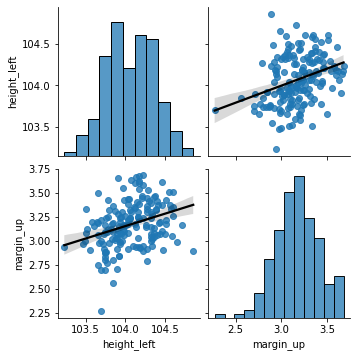

In [15]:
#on étudie les var les plus corrélées révélées par la matrice de corrélation
sns.pairplot(df[['height_left',\
'margin_up']],kind="reg", plot_kws={'line_kws':{'color':'black'}})
#plt.savefig("elbow_for_best_k.pdf")

Text(0.5, 1.0, 'log reg of margin_up into is_genuine')

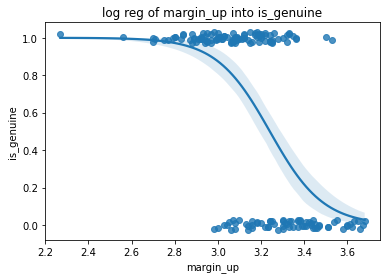

In [16]:
# on fait différents test pour observer graphiquement la qualité des variables pour une Reg Log
# on remaqrque que les var 'diagonal, height_right' ne semblent pas pas pertinente dans ce modèle : 
# sa courbe ressemble presque à une droite
sns.regplot(x="margin_up", y="is_genuine", data=df[['margin_up', 'is_genuine']],

                 logistic=True, n_boot=500, y_jitter=.03)
plt.title('log reg of margin_up into is_genuine')
#plt.savefig("LogReg_example.png")

<AxesSubplot:xlabel='height_left', ylabel='is_genuine'>

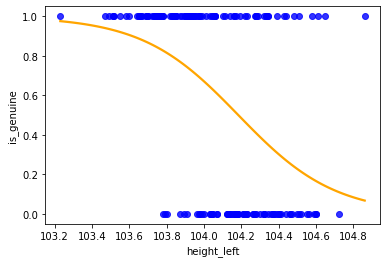

In [17]:
#plot logistic regression avec uniquement la var height_left
sns.regplot(x=df.height_left, y=df.is_genuine, data=df[['height_left', 'is_genuine']], logistic=True, ci=None,
            scatter_kws={'color': 'blue'}, line_kws={'color': 'orange'})

In [18]:
#On a une variable 
#H0 la variable suit une Loi normale
#H1 la variable ne suit pas une Loi normale
shapiro(df["margin_up"]), shapiro(df["height_left"])

(ShapiroResult(statistic=0.9889172315597534, pvalue=0.20443524420261383),
 ShapiroResult(statistic=0.9927234649658203, pvalue=0.5533669590950012))

In [19]:
#### => on trouve que p>>0.05 Donc le hasard pourrait causer qu'on n'observe pas une distribution normale de notre dataset

### 2. Réduction de la dimension (on emprunte à la méthode Epimed université de Grenoble)
https://github.com/epimed/eoc-ai-session-2/blob/main/notebook/demo_pca_tsne_umap.ipynb

In [20]:
# Données des caractéristiques de pays, on split le jeur de données
data_df = df.drop(['is_genuine','cluster'], axis=1)
X = data_df.select_dtypes('number') 
#on mets la var cluster dans un objet séparé, elle ne fait pas partie des données à analyser
#mais elle nous servira pour comparer la classification k-means vs. structure graphique PCA
y = df['is_genuine']

<AxesSubplot:ylabel='Distribution'>

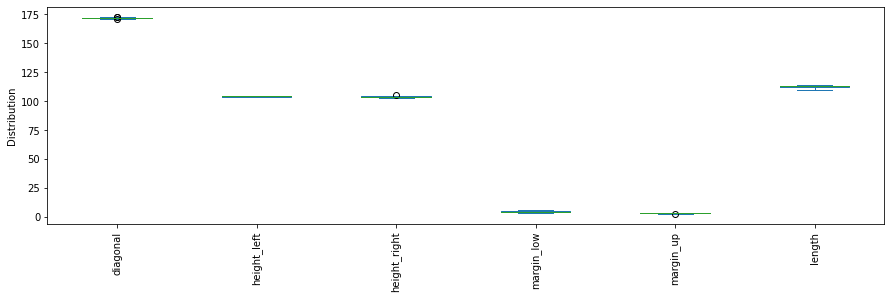

In [21]:
#on observe la variance des variables
X.plot(kind='box', figsize=(15, 4), rot=90, ylabel='Distribution')

In [22]:
scaler = StandardScaler() # instanciation de l'objet scaler
X_scaled = scaler.fit_transform(X) # normalisation centrée-réduite
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # conversion du résultat en objet dataframe de pandas

In [23]:
X_scaled.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.428344,2.669454,3.096563,-0.131590,-1.189874,0.281633
1,-0.887559,-1.097697,-0.691254,-0.860126,-1.274740,0.780697
2,-0.362742,-1.030427,-0.509439,-0.303010,-1.232307,1.377405
3,-0.461145,-0.963156,-0.842767,-1.260106,-0.213913,1.149571
4,0.358883,-1.232238,-0.539742,0.611230,-3.820725,1.062777


<AxesSubplot:ylabel='Distribution'>

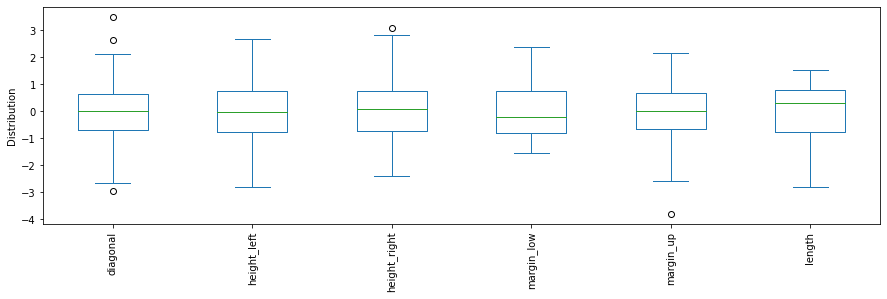

In [24]:
X_scaled.plot(kind='box', figsize=(15, 4), rot=90, ylabel='Distribution')

In [25]:
#On plot les coordonnées en 6 dimensions dans le plan engendré par les eigenvecteurs
pca = PCA() # instanciation de l'objet pca
X_p = pca.fit_transform(X_scaled)
pca_columns = ['PC' + str(c) for c in range(1, X_p.shape[1]+1, 1)]

X_pca = pd.DataFrame(X_p, index=X.index, columns=pca_columns) # création du dataframe
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,2.153639,1.599709,1.787451,2.433465,0.699690,-1.267702
1,-2.110416,-0.526039,0.542563,0.344550,0.067440,-0.544601
2,-1.973152,-0.048102,0.858716,0.374812,-0.424886,0.080487
3,-2.059795,-0.089105,-0.531529,0.519548,-0.033267,-0.038261
4,-2.403180,0.412170,3.319507,-0.837043,-0.420151,-0.445099


In [26]:
#print(pca.explained_variance_ratio_)
explained_variance = pd.Series(dict(zip(X_pca.columns, 100.0*pca.explained_variance_ratio_)))
print(explained_variance)

PC1    47.447921
PC2    21.957106
PC3    14.234524
PC4     8.526295
PC5     4.612822
PC6     3.221331
dtype: float64


<AxesSubplot:title={'center':'Ebouli des valeurs propres en termes de variance relative'}, ylabel='explained Variance'>

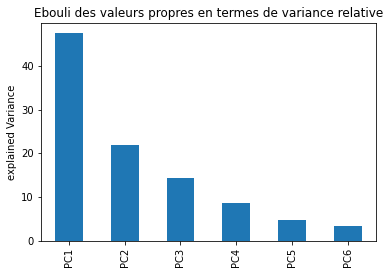

In [27]:
explained_variance.plot(kind='bar', title="Ebouli des valeurs propres en termes de variance relative", ylabel='explained Variance')

In [28]:
PCnames = ['PC'+str(i+1) for i in range(pca.n_components_)]
Loadings = pd.DataFrame(pca.components_,columns=PCnames,index=X.columns)

Loadings.style\
    .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)\
    .format(precision=2)

,PC1,PC2,PC3,PC4,PC5,PC6
diagonal,0.07,0.48,0.49,0.43,0.35,-0.47
height_left,0.78,0.34,0.24,-0.32,-0.14,0.31
height_right,-0.09,0.12,0.15,0.51,-0.82,0.13
margin_low,-0.56,0.28,0.46,-0.23,0.14,0.57
margin_up,-0.23,0.72,-0.49,-0.31,-0.19,-0.25
length,0.12,0.23,-0.48,0.55,0.35,0.52


#### variables qui contribuent bcp aux PC qui maximisent la Variance : height_left, margin_low, margin_up. height_left et margin_up sont justement des variables qui passent le test de Shapiro de normalité (donc éligibles quant à ce critère pour une régression logistique)

Text(0.5, 1.0, 'ébouli des valeurs propres')

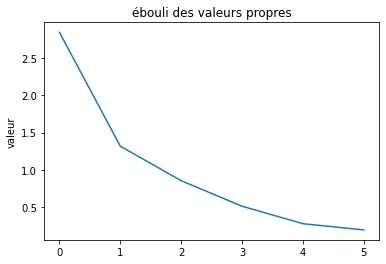

In [29]:
#calculs eigenvalues
n = X_scaled.shape[0]
eigval = (n-1)/n*pca.explained_variance_
#eigval.plot(kind='bar')
plt.plot(eigval)
plt.ylabel("valeur")
plt.title('ébouli des valeurs propres')
#plt.savefig("valeurs_propres.pdf")

In [30]:
X_scaled.shape

(170, 6)

In [31]:
X_scaled.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.428344,2.669454,3.096563,-0.131590,-1.189874,0.281633
1,-0.887559,-1.097697,-0.691254,-0.860126,-1.274740,0.780697
2,-0.362742,-1.030427,-0.509439,-0.303010,-1.232307,1.377405
3,-0.461145,-0.963156,-0.842767,-1.260106,-0.213913,1.149571
4,0.358883,-1.232238,-0.539742,0.611230,-3.820725,1.062777


In [32]:
#On fait une matrice de covariance
covMatrix = np.cov(X_scaled)#,bias=True)
covDf = pd.DataFrame(covMatrix)#,columns=PCnames,index=X.columns)

sol2 = (covDf.where(np.triu(np.ones(covDf.shape), k=0).astype(bool)))
                  #.stack()
                  #.sort_values(ascending=False))
sol2.head()
#covDf

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,3.066405,0.009291,-0.160552,-0.476566,0.440102,1.286347,-0.669028,-0.929719,-1.217434,0.850467,...,-1.108878,0.904260,0.170562,0.092409,0.547432,0.100502,0.683608,-0.026784,-0.682014,-0.309804
1,NaN,0.547414,0.665564,0.512437,0.838037,0.019653,0.490120,0.479744,0.409234,-0.065483,...,-0.847092,-0.654826,-0.361647,-0.519511,-0.264796,-0.569515,-0.790635,-0.827188,-0.376083,-0.592156
2,NaN,NaN,0.850581,0.585591,1.235795,0.026195,0.714953,0.528285,0.506337,-0.080171,...,-1.026134,-0.782057,-0.402502,-0.592934,-0.331587,-0.727150,-0.818194,-0.941281,-0.495615,-0.628928
3,NaN,NaN,NaN,0.737279,0.241498,-0.162091,0.560271,0.829791,0.732255,-0.235829,...,-0.313385,-0.915274,-0.627966,-0.752204,-0.597485,-0.535698,-0.996029,-0.808294,-0.149290,-0.759005
4,NaN,NaN,NaN,NaN,3.185504,0.840113,1.274111,-0.196090,-0.036819,0.397819,...,-1.848359,-0.370404,-0.215843,-0.518120,-0.202470,-1.137385,0.335735,-0.775482,-1.286283,-0.432428


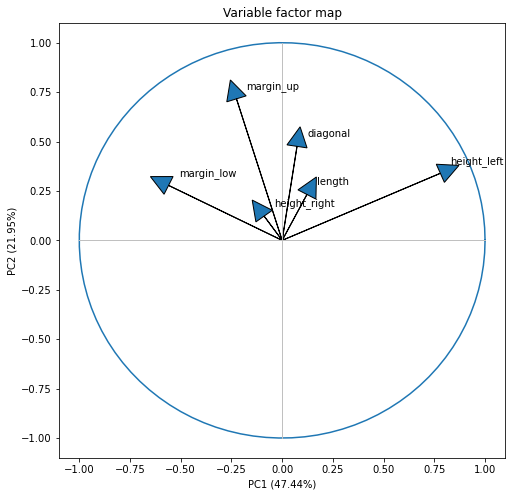

In [33]:
# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[0]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[i, 0],  #0 for PC1
             pca.components_[i, 1],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[i, 0] + 0.05,
             pca.components_[i, 1] + 0.05,
             X.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

plt.xlabel("PC1 (%s%%)" % str(explained_variance[0])[:5].lstrip("0."))
plt.ylabel("PC2 (%s%%)" % str(explained_variance[1])[:5].lstrip("0."))
ax.set_title('Variable factor map')
#plt.savefig("correlation_circle.png")
plt.show()

In [34]:
y.sample(5)

56     1
113    0
167    0
149    0
11     1
Name: is_genuine, dtype: uint8

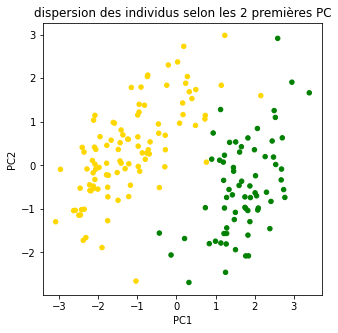

In [35]:
#On projette sur le plan généré par les 2 composantes principales qui comptent pour ~ 68% de la variabilité des données
colors = {0:'green', 1:'gold'}
X_pca.plot(x='PC1', y='PC2', kind='scatter', c=y.map(colors), figsize=(5, 5))
plt.title('dispersion des individus selon les 2 premières PC')

#plt.savefig("PCA_plane.png")
plt.show()

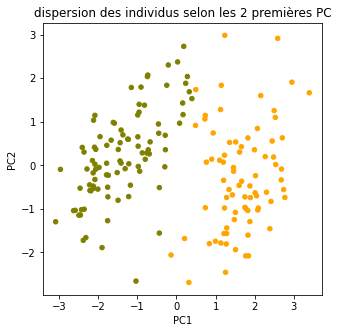

In [36]:
#On projette sur le plan généré par les 2 composantes principales qui comptent pour ~ 68% de la variabilité des données
colors2 = {0:'olive', 1:'orange'}
X_pca.plot(x='PC1', y='PC2', kind='scatter', c=df['cluster'].map(colors2), figsize=(5, 5))
plt.title('dispersion des individus selon les 2 premières PC')

#plt.savefig("PCA_plane.png")
plt.show()

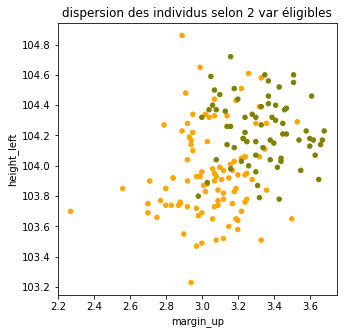

In [37]:
#On plot
colors3 = {0:'darkolivegreen', 1:'yellow'}
df.plot(x='margin_up', y='height_left', kind='scatter', c=y.map(colors2), figsize=(5, 5))
plt.title('dispersion des individus selon 2 var éligibles')

#plt.savefig("PCA_plane.png")
plt.show()

#### => on observe pas 2 groupes bien distincts

## 3. Machine learning par régression logistique

### hypothèses : 
Les variables séléctionnées ne sont pas corrélées entre elles-> vérifié\
Le terme d'erreur suit une Loi normale
### observations : 
On split le dataset entre un échantillon d'entrainement et un echantillon de test\
l'intérêt de cette fonction est que les groupes train/test sont constitué ) partir d'individus séléctionnés de manière aléatoire\
On scale pour mettre les var sur pied d'égalité

In [38]:
#random state=42 pour fixer
dat = X_scaled[['margin_up','height_left']]
X_train, X_test, y_train, y_test = train_test_split(dat, y, random_state=42)

### La tranche de données de test permet de se faire une idée de la performance du modèle avant de faire des prédictions sur des échantillons inconnus

In [39]:
#la tranche de test represente 1/3 des individus
len(X_train)/(len(X_test)+len(X_train))

0.7470588235294118

In [40]:
#on instancie LogReg
LogReg = LogisticRegression(solver='lbfgs')
LogReg.fit(X_train, y_train)

LogisticRegression()

In [41]:
#on mesure le score d'exactitude moyenne
LogReg.score(X_test, y_test)

0.7906976744186046

In [42]:
# Check trained model intercept
print(LogReg.intercept_)

# Check trained model coefficients
print(LogReg.coef_)

[0.78577838]
[[-1.75788442 -0.92471668]]


In [43]:
#coef
pd.DataFrame(zip(dat.columns, np.hstack(LogReg.coef_)), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,margin_up,-1.757884
1,height_left,-0.924717


In [44]:
#on reconstitue un dataframe avec les données scaled + la colonne 'is_genuine'
data = pd.concat([X_scaled, df[['is_genuine']]], axis=1)
data.sample(5)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
70,-2.954029,-0.761344,-0.873070,-0.560140,0.804481,0.140593,1
121,0.424485,1.458584,0.914780,2.254006,-0.426078,-1.475941,0
159,-0.723554,1.324043,0.581452,-0.574425,1.865309,-2.452371,0
58,0.490087,-0.021368,-0.085204,-0.917266,0.634749,0.563713,1
150,0.030872,0.651337,0.126914,1.811171,-0.044180,-0.141487,0


### On fait une logistic regression en Statsmodels pour comparer avec Scikitlearn

In [45]:
# fit logistic regression model
from statsmodels.formula.api import logit, glm, ols

# statsmodels works nicely with pandas dataframes
#dat = pd.DataFrame(data, columns = ['Temperature', 'Failure'])
logit_model = logit('is_genuine ~ height_left + margin_up',data).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.398205
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                          Logit   Df Residuals:                      167
Method:                           MLE   Df Model:                            2
Date:                Thu, 31 Mar 2022   Pseudo R-squ.:                  0.4122
Time:                        09:46:20   Log-Likelihood:                -67.695
converged:                       True   LL-Null:                       -115.17
Covariance Type:            nonrobust   LLR p-value:                 2.399e-21
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7235      0.230      3.148      0.002       0.273       1.174
height_left    -1.0582    

#### interprétation : 
_si les variables sont nulles, la p que le billet soit 'genuine' est ~2.06 (exp(beta0)) fois plus grande que la p que le billet soit faux\
_si la var 'height_left' augmente d'une unité, le rapport des côtes que le billet soit 'genuine' devient 0.34 (exp(-1.0582)) fois moins grand\
_même calcul var 'margin_up'\
_les p-values sont <0.05 donc les coef et relations entre les var et y ne sont dues au hasard

## Outil de prédiction

In [46]:
#on teste sur l'échantillon de test de l'énnoncé ou de l'évaluation
df2 = pd.read_csv("test_notes.csv")
#on mets en forme un index
df2 = df2.set_index('id')

In [47]:
#on insère données à prédire ici (remplacer test_notes par df2)
ScaledSample = scaler.fit_transform(df2[['height_left','margin_up']])
#remplacer test_notes par df2 pour l'index
ScaledSample_df = pd.DataFrame(ScaledSample, index=df2.index,\
                               columns=df2[['height_left','margin_up']].columns)
ScaledSample_df

,height_left,margin_up
id,,
B_1,-0.639418,-0.937158
B_2,0.552718,-0.137145
B_3,-1.452239,0.777156
B_4,0.065026,1.462881
B_5,1.473914,-1.165733


In [48]:
#on utilise la méthode predict pour predire le resultat
LogReg.predict(ScaledSample_df)

array([1, 0, 1, 0, 0], dtype=uint8)

In [49]:
#probas
proba = LogReg.predict_proba(ScaledSample_df)
#mise en forme resultat dans un Df Attention à indiquer le bon df pour l'index
proba_predict = pd.DataFrame(proba, index=df2.index, columns=['p_not_genuine', 'p_is_genuine'])

In [50]:
#résultat
proba_predict['prediction'] = np.where(proba_predict['p_is_genuine']>=0.5,'genuine','fake')
proba_predict

,p_not_genuine,p_is_genuine,prediction
id,,,
B_1,0.058612,0.941388,genuine
B_2,0.514749,0.485251,fake
B_3,0.067862,0.932138,genuine
B_4,0.664024,0.335976,fake
B_5,0.674195,0.325805,fake


Text(0.5, 1.0, 'Predicted is_genuine: $\\hat{Y}_i$ count')

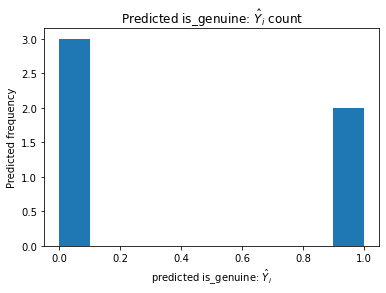

In [51]:
#on plot la distribution
plt.hist(LogReg.predict(ScaledSample_df))
plt.xlabel("predicted is_genuine: $\hat{Y}_i$")
plt.ylabel("Predicted frequency")
plt.title("Predicted is_genuine: $\hat{Y}_i$ count")